# Spatial Regression with Partial Differential Equation Regularization
Ilenia Di Battista, Alessandro Palummo @ fdaPDE Team, MOX, Department of Mathematics, Politecnico di Milano, Italy

`fdaPDE`(Palummo et al., 2025) is a C++ library with an interface to R and Python for *physics-informed spatial and functional data analysis*, at the intersection between statistics and numerical analysis. The library provides advanced statistical methods designed for data located over complex spatial domains, ranging from irregular planar regions and curved surfaces to linear networks and volumes, possibly evolving over time. The class of methods implemented in `fdaPDE` features regularization terms based on Partial Differential Equations (PDEs), which allow incorporating prior physical knowledge erived from the physics of the problem under study into the statistical modeling. This makes `fdaPDE` an extremely flexible tool for the analysis of complex data. For a review of this class of methods, refer to Sangalli (2021).

This notebook describes the `fdaPDE` Python interface for **spatial regression methods**.

## Model

Let $\mathcal{D} \subset \mathbb{R}^d\,,$ with $d \geq 1\,,$ be a bounded *spatial domain* of interest in which $n$ fixed *measurement stations* are located. Here, we consider $d = 2\,,$ but the proposed method can handle multidimensional spatial domains with complex shapes, including *two-dimensional curved surfaces* (Ettinger et al., 2016) and *non-convex three-dimensional volumes*  (Arnone et al., 2023). At location $\mathbf{p}_i =(p_{1i}, p_{2i})^\top \in \mathcal{D}$ of the $i$-th measurement station, we observe a response variable $y_i \in \mathbb{R}$ of interest, possibly along with a set of covariates $\mathbf{x}_i = \left( x_{i,1},\ldots,x_{i,q} \right)^\top \in \mathbb{R}^q\,,$. We model the relationship between the response variable and the covariate with a **semiparametric spatial regression model**, which we formulate as follows:
$$y_i = \mathbf{x}_i^\top \boldsymbol{\beta} + f(\mathbf{p}_i) + \varepsilon_i\,, \qquad i = 1, \ldots, n\,,$$

where:
  
- $\boldsymbol{\beta} \in \mathbb{R}^q$ is a vector of **unknown regression coefficients** capturing the mean effects of the covariates;

- $f(\mathbf{p}_i) \in \mathbb{R}$ is an **unknown deterministic spatial field** $f : \mathcal{D} \to \mathbb{R}$ at the $i$th data location;

- $\varepsilon_i \in \mathbb{R}$ is the **measurement error** at the $i$-th spatial location; in particular, errors $\varepsilon_1, \ldots, \varepsilon_n$ are assumed to be independent and identically distributed, having *zero mean* and *finite variance* $\sigma^2\,.$

To estimate the unknown parameters, we refer to the basic form of physics-informed methods, as reviewed in Sangalli (2021) and originally introduced in Sangalli et al. (2013). Specifically, we here assume the availability of prior physical knowledege which can be described by a Partial Differential Equation (PDE) $Lf = u$. Here $L$ denotes a **second-order, elliptic, differential operator** of the following form
$$Lf = -\nabla \cdot (K \nabla f) + \mathbf{b} \cdot \nabla f + cf\,,$$
where

- $K \in \mathbb{R}^{2\times2}$ defines a symmetric and positive definite **diffusion tensor**, which models potential anisotropy;

- $\mathbf{b} \in \mathbb{R}^2$ defines a **transport field**, modeling one-directional effects typical of stream currents or winds;

- $c \in \mathbb{R}^+$ defins a **reaction coefficient**, which is responsible for shrinking the field $f$ to zero.

The **forcing term** $u$ models possible external forces driving the phenomenon. Each of these parameters can vary over space and contribute to modeling different forms of anisotropy and non-stationarity. Consistent with the application presented in this vignette, we will focus on homogeneous forcing terms $u \equiv 0\,.$ For non-homogeneous forcing terms, refer to Azzimonti et al. (2014), Azzimonti et al. (2015), and Arnone et al. (2019). In the case no prior knowledge is available, the uninformed Laplacian operator $L = \Delta$ can be used to induce *stationary and isotropic smoothing*. Moreover, problem-specific conditions on $f$ may be imposed at the boundary $\partial\mathcal{D}$ of the spatial domain. The method currently supports Dirichlet, Neumann, and Robin boundary conditions, which respectively set the value of $f$ at $\partial\mathcal{D}\,,$ its normal derivative at $\partial\mathcal{D}\,,$ or a combination of both.

Following the well-established literature on physics informed regression, we hence propose to estimate the unknown regression coefficient vector $\boldsymbol{\beta}$ and unknown spatial field $f$ by minimization of the following penalized least-square functional:
$$\frac{1}{n} \sum_{i = 1}^n \left( y_i - \mathbf{x}_i^\top \boldsymbol{\beta} - f(\mathbf{p}_i) \right)^2 + \lambda \int_{\mathcal{D}} (Lf - u)^2\,,$$

The functional above embodies a trade-off between *data fidelity* and *model fidelity* through the least-squares term and the misfit with respect to the PDE, respectively. The balance between these two contributions is governed by the smoothing parameter $\lambda \in \mathbb{R}^+\,.$
   
Despite the statistical, numerical, computational and analytical complexities underlying these methodologies, we show how the `fdaPDE` library enables user to focus on the data analysis rather than on the implementation details, thanks to a user-friendly Python interface designed for a statistical audience.
In this notebook, we import the modules of the `fdaPDE` library individually to highlight the purpose of each module.
First, we load some additional Python libraries and helper functions for plotting:

In this notebook, we import the modules of the `fdaPDE` library individually to highlight the organization of the library.
First, we load some external Python libraries and helper functions used only for graphical purposes:

In [1]:
# Import additional libraries 
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
import rioxarray as rxr
from IPython.display import Image, display


# Load helper functions for plotting
import sys
sys.path.append("..")

from utils.utils import (
    plot_domain,
    display_satellite_data,
    display_folium_map
)

## Application to oceanographic quantities around the Florida peninsula

As a benchmark application in environmental sciences, we consider *oceanographic data* in the Gulf of Mexico, around the Florida peninsula. Tomasetto et al. (2024) presents this application in the context of spatial regression with differential regularization, proposing a *parameter cascading* approach for the estimation of PDE parameters, building on a first investigation by  Bernardi et al. (2018). The dataset contains some indicators of water quality measured at 30 moored buoys, serving as monitoring stations, on April 1, 2020. In particular, we consider the **Sea Surface Temperature** (SST) and **Dissolved Oxygen** (DO) at standard depth levels. The dataset is freely and publicly available by different data sources, including the [National Data Buoy Center](https://www.ndbc.noaa.gov/) and the [National Centers for Environmental Information](https://www.ncei.noaa.gov/archive/accession/NCEI-WOA18) of the National Oceanic and Atmospheric Administration (NOAA). SST is vital for marine ecosystems, weather prediction, and climate monitoring, influencing biological activity, atmospheric circulation, and heat absorption from climate change. On the other hand, DO is a key indicator of aquatic ecosystem health, essential for marine life and water quality. Monitoring its spatial distribution aids in the early detection and mitigation of environmental issues.



### 1. Spatial domain

The first step in any `fdaPDE` workflow is the definition of the geometrical region in which data are located. 

We load the geometry of the **spatial domain** under study, created by preprocessing the Florida administrative boundary. This stage includes defining the specific region of interest located in the Gulf of Mexico, removing minor islands, and reducing the resolution of the coastlines. 

The preprocessed geometry of the spatial domain is available from the file `SRPDE_2D/SRPDE_2D_domain.shx` and can be loaded through the `geopandas` Python package (GeoPandas Developers, 2024).

In [2]:
## [SPATIAL DOMAIN]
# Load domain
domain = gpd.read_file("../Data/SRPDE_2D/domain.shx")
domain


NAME                                           geometry
0  Gulf of Mexico  POLYGON ((-78.975 30.655, -78.975 23.305, -85....

The spatial domain can be interactively visualized using the `folium` Python package (Python Visualization Team, 2024).

In [3]:
# Intercative plot
plot_domain(
    domain_shape = domain,
    fill_color   = "grey",
    border_color = "black",
    fill_opacity = 0.5,
    zoom_start   = 6
)

Figure 1: Spatial domain of interest -- a portion of the Gulf of Mexico around the Florida peninsula.

As the discussed methodologies rely on finite elements for the numerical resolution of the estimation problem, we need to build a suitable triangulation of the spatial region of interest, i.e., a finite union of non-overlapping triangles. This construction is necessary to define the discrete functional basis used to find a discrete solution to the estimation problem.

For simplicity, we here import an already generated **regular mesh** of the spatial domain under consideration. Specifically, we import the mesh nodes, the mesh triangles and a description of the domain boundary.

In [4]:
## [MESH]
# Read mesh nodes, boundary nodes and mesh elements
mesh_nodes          = np.loadtxt("../Data/SRPDE_2D/nodes.txt"          , dtype = float)
mesh_cells          = np.loadtxt("../Data/SRPDE_2D/cells.txt"          , dtype = int  )
mesh_boundary_nodes = np.loadtxt("../Data/SRPDE_2D/boundary_coords.txt", dtype = float)
mesh_boundary       = np.loadtxt("../Data/SRPDE_2D/boundary.txt"       , dtype = float)

# Print shapes
print(f"Mesh nodes shape: {mesh_nodes.shape}")
print(f"Mesh cells shape: {mesh_cells.shape}\n")

# Print first 5 boundary nodes
print("First 5 coordinates of boundary nodes (lon/lat):")
print(mesh_boundary_nodes[:5, :], "\n")

# Print first 5 boundary indice
print("First 5 values of the boundary node list (0/1):")
print(mesh_boundary[:5])

Mesh nodes shape: (2851, 2)
Mesh cells shape: (5342, 3)

First 5 coordinates of boundary nodes (lon/lat):
[[-78.975       30.655     ]
 [-78.975       23.305     ]
 [-85.275       23.305     ]
 [-85.275       29.69238221]
 [-85.121473    29.715854  ]] 

First 5 values of the boundary node list (0/1):
[1. 1. 1. 1. 1.]


Next, we embed this informations into an object of class `Mesh`, loaded from the geometry module of the `fdaPDE` library.

In [5]:
# Import Mesh from the geometry module
from fdaPDE.geometry import Mesh

# Define mesh of the spatial domain
mesh_florida = Mesh(
    nodes    = mesh_nodes,
    cells    = mesh_cells,
    boundary = mesh_boundary
)

# Print short summary of the mesh
print(mesh_florida)

2D mesh
Bounding box:   xmin: -85.275 ymin: 23.305 xmax: -78.975 ymax: 30.655
Number of nodes: 2851
Number of cells: 5342


We visualize the resulting mesh of the spatial domain of interest using the `mapplot` method of the `Mesh` class.

In [6]:
# Interactive plot
mesh_florida.mapplot(
    domain_fill_opacity = 0.3,
    boundary_nodes      = mesh_boundary_nodes,
    zoom_start          = 6,
    mesh_weight         = 0.6,
    mesh_opacity        = 0.7
)

Figure 2: Regular mesh of the spatial domain of interest around the Florida peninsula with $2\,851$ nodes and $5\,342$ triangles.

### 2. Data

To facilitate the managment of spatial data, `fdaPDE` introduces the `GeoFrame` data structure, a multilayer container of spatially referenced data, possibly observed over different supports. A `GeoFrame` is natively built to support discretized geometries, and is fully integrated with the `fdaPDE` workflow.

A `GeoFrame` object is always constructed starting from a `Mesh` object, defining the spatial support of the analysis.

In [7]:
# Import GeoFrame from fdaPDE
from fdaPDE import GeoFrame

# Create the geoframe
florida = GeoFrame(domain = mesh_florida)
print(florida)

Geoframe with 0 layers
Bounding box:   xmin: -85.275 ymin: 23.305 xmax: -78.975 ymax: 30.655
Number of nodes: 2851
Number of cells: 5342



We import the preprocessed data from the file `SRPDE_2D_data.txt` using the utilities provided by the `pandas` package.

In [8]:
## [DATA]
# Load the data
data = pd.read_table("../Data/SRPDE_2D/data.txt", sep=r"\s+", index_col=0)

print(data.shape)
data.head()

(30, 8)


lon    lat     SST          DO   Nitrate  Phosphate   Salinity  Silicate
1 -81.11  24.71  26.535  207.854017  0.125092   0.093190  36.082402  1.476339
2 -80.40  25.00  25.661  208.586600  0.115277   0.107791  36.101338  1.840899
3 -81.90  23.90  27.383  205.318180  0.125819   0.116948  36.128202  1.745409
4 -83.60  24.60  25.540  208.723705  0.221984   0.068816  36.309676  1.074786
5 -80.90  24.80  26.430  208.586600  0.115277   0.107791  36.117646  1.840899

As the buoy observations are georeferenced, we add to the `florida` data structure a `point` data layer. A `point` layer references one or more quantities to a single point located within the spatial domain, in this setting corresponding to the buoy geographical position.

In [9]:
# Add layer with data to the geoframe object
florida.insert("ocean", layer_type = "point", geo = ["lon", "lat"], data = data)

print(florida)

Geoframe with 1 layer
Bounding box:   xmin: -85.275 ymin: 23.305 xmax: -78.975 ymax: 30.655
Number of nodes: 2851
Number of cells: 5342

Layer: ocean
Type:  POINT
Dims:  30, 6
First 6 data rows:
                               SST         DO  Nitrate Phosphate  Salinity Silicate
                 <POINT>   <flt64>    <flt64>  <flt64>   <flt64>   <flt64>  <flt64>
 (-81.110000, 24.710000) 26.535000 207.854017 0.125092  0.093190 36.082402 1.476339
 (-80.400000, 25.000000) 25.661000 208.586600 0.115277  0.107791 36.101338 1.840899
 (-81.900000, 23.900000) 27.383000 205.318180 0.125819  0.116948 36.128202 1.745409
 (-83.600000, 24.600000) 25.540000 208.723705 0.221984  0.068816 36.309676 1.074786
 (-80.900000, 24.800000) 26.430000 208.586600 0.115277  0.107791 36.117646 1.840899
 (-81.100000, 24.300000) 27.037000 207.854017 0.125092  0.093190 36.089488 1.476339



In [10]:
print(f"Geoframe number of layers: {florida.n_layers}")
print(f"Geoframe layer name: {florida.names}")
print(f"Geoframe layer columns names: {florida.colnames}")

print("Geoframe mesh information:")
print(florida.mesh)

print("Geoframe data information:")
print(florida["ocean"])

Geoframe number of layers: 1
Geoframe layer name: ['ocean']
Geoframe layer columns names: ['SST', 'DO', 'Nitrate', 'Phosphate', 'Salinity', 'Silicate']
Geoframe mesh information:
2D mesh
Bounding box:   xmin: -85.275 ymin: 23.305 xmax: -78.975 ymax: 30.655
Number of nodes: 2851
Number of cells: 5342
Geoframe data information:
                               SST         DO  Nitrate Phosphate  Salinity Silicate
                 <POINT>   <flt64>    <flt64>  <flt64>   <flt64>   <flt64>  <flt64>
 (-81.110000, 24.710000) 26.535000 207.854017 0.125092  0.093190 36.082402 1.476339
 (-80.400000, 25.000000) 25.661000 208.586600 0.115277  0.107791 36.101338 1.840899
 (-81.900000, 23.900000) 27.383000 205.318180 0.125819  0.116948 36.128202 1.745409
 (-83.600000, 24.600000) 25.540000 208.723705 0.221984  0.068816 36.309676 1.074786
 (-80.900000, 24.800000) 26.430000 208.586600 0.115277  0.107791 36.117646 1.840899
 (-81.100000, 24.300000) 27.037000 207.854017 0.125092  0.093190 36.089488 1.476339


The recorded values are shown in the interactive plot below.

In [11]:
# Interactive plot
m_sst       = florida["ocean"].mapplot("SST",       boundary_nodes=mesh_boundary_nodes, cmap_name="magma"  )
m_do        = florida["ocean"].mapplot("DO",        boundary_nodes=mesh_boundary_nodes, cmap_name="viridis")
m_nitrate   = florida["ocean"].mapplot("Nitrate",   boundary_nodes=mesh_boundary_nodes, cmap_name="viridis")
m_phosphate = florida["ocean"].mapplot("Phosphate", boundary_nodes=mesh_boundary_nodes, cmap_name="viridis")
m_salinity  = florida["ocean"].mapplot("Salinity",  boundary_nodes=mesh_boundary_nodes, cmap_name="viridis")
m_silicate  = florida["ocean"].mapplot("Silicate",  boundary_nodes=mesh_boundary_nodes, cmap_name="viridis")

display_folium_map(
    maps=[m_sst, m_do, m_nitrate, m_phosphate, m_salinity, m_silicate],
    nrows=2,
    ncols=3,
    cell_height="500px"
)

Figure 3: Sea Surface Temperature (SST), Dissolved Oxygen (DO), and concentrations of Nitrate, Phosphate, Salinity, and Silicate, observed at 30 monitoring stations located in the Gulf of Mexico, around the Florida peninsula, on April 1, 2020.

In this example, we focus on the study of the Sea Surface Temperature (SST) variable. The *non-standard shape* of the spatial domain strongly influences the oceanographic quantity under study. For example, temperatures recorded at two buoys located on opposite sides of the Florida peninsula are naturally less correlated than those recorded at two buoys situated the same distance apart but on the same side of the peninsula. As shown later, `SR-PDE` naturally accounts for the geometry of the domain, and enables the introduction of additional physical knowledge driving the sea temperature.

#### 2.1 SST satellite images
In addition to the data introduced above, the file `SRPDE_2D/SST.tif` contains a `GeoTIFF` raster dataset of SST values observed from high resolution satellite images provided by the Jet Propulsion Laboratory of the [National Aeronautics and Space Administration (NASA)](https://podaac.jpl.nasa.gov/dataset/MUR-JPL-L4-GLOB-v4.1). The file is read using the `Rasterio` Python package (Rasterio contributors, 2025).

In [12]:
# Load the SST data from NASA satellite images
raster_path = "../Data/SRPDE_2D/SST.tif"

with rasterio.open(raster_path) as src:
    sst       = src.read(1, masked=True)         
    transform = src.transform  
    crs       = src.crs
    bounds    = src.bounds


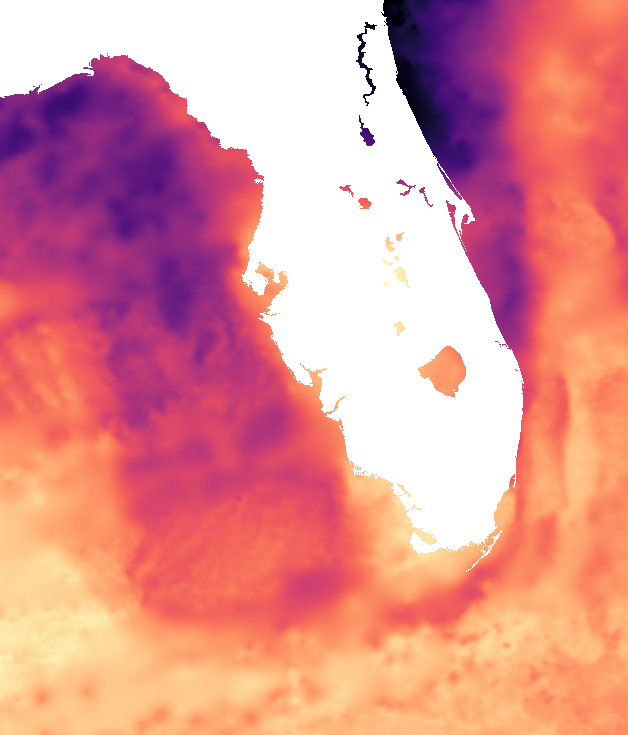

In [13]:
# Interactive plot
m_satellite = display_satellite_data(raster_path = "../Data/SRPDE_2D/SST.tif", layer_name = "Satellite SST", boundary_nodes = mesh_boundary_nodes)

display_folium_map([m_satellite])

Figure 4: SST data from NASA satellite images, used solely for comparison with the SST estimates computed by the proposed `SR-PDE` method in the next section.

We point out that **these data are not used for estimation purposes**; they are displayed here solely to enable comparison with respect to the SST estimate provided by the proposed `SR-PDE` method in the next section. Instead, the estimation is performed using the 30 observations measured at the moored buoys, contained in the `florida` variable previously defined.

### 3. SR-PDE model fitting for isotropic smoothing (without covariates)

Once the geometry and the data are defined, we are ready to estimate the SST using the here discussed spatial regression method, accessible via the `SRPDE` data type. This type offers several options for solving the regression problem, including the possibility to specify covariates, PDE parameters, and boundary conditions.

We start by applying an uninformative, isotropic smoothing model to the SST data, hereafter referred to as `SR-PDE`$(I,\mathbf{0},0)\,.$ This means that we consider:

- a **stationary and isotropic diffusion tensor**: $K = I\,,$ where $I$ is the identity matrix;

- a **null transport vector**: $\mathbf{b}(\mathbf{p}) = \mathbf{0}\,;$

- a **null reaction coefficient**: $c = 0\,;$

- a **null forcing term**: $u \equiv 0\,.$

#### 3.1 Isotropic smoothing with fixed smoothing parameter

As a first attempt, we fit the model with a fixed proposed value for the smoothing parameter $\lambda\,.$ The following code shows how to obtaine an estimate for the SST when the smoothing parameter is set to $0.001\,$:

In [14]:
# Import FeFunction, SRPDE from fdaPDE
from fdaPDE.fem import FeFunction
from fdaPDE.models import SRPDE

## [ISOTROPIC SMOOTHING WITH FIXED SMOOTHING PARAMETER]
# Set up the finite element function (order 1)
f_SST_iso_fixed = FeFunction(domain = mesh_florida, fe_type = "P1")

# Proposed value for the smoothing parameter
lambda_fixed = 0.001  

# Isotropic smoothing model
model_SST_iso_fixed = SRPDE("SST ~ f_SST_iso_fixed", data = florida, penalty = None)

# Isotropic smoothing fit with fixed lambda
fit_SST_iso_fixed = model_SST_iso_fixed.fit(lambda_ = lambda_fixed)

We can inspect the regression model outputs:

In [15]:
# Fitted values at mesh nodes
print(f_SST_iso_fixed.coeff[:5])

print(model_SST_iso_fixed.f[:5])

[24.03966949 25.94342182 27.93464545 24.01590317 24.01718876]
[24.03966949 25.94342182 27.93464545 24.01590317 24.01718876]


In [16]:
# Fitted values at locations
print(model_SST_iso_fixed.fitted[:5])

[26.69062307 25.86232724 27.11475146 26.04543969 26.45413675]


The `mapplot` method available from objects of type `FeFunction` allow us to easily obtain a visual representation of the estimated field: 


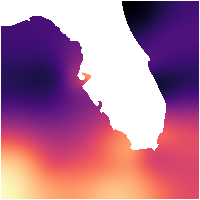

In [17]:
# Interactive plot 
m_iso_fixed = f_SST_iso_fixed.mapplot(
    boundary_nodes = mesh_boundary_nodes,
    layer_name     = "SST",
    zoom_start     = 6,
    cmap_name      = "magma",
    border_weight  = 3
)

display_folium_map([m_iso_fixed])

Figure 5: SST estimate provided by the isotropic `SR-PDE`$(I,\mathbf{0},0)$ without covariates and with $\lambda = 0.001$. We recall that the proposed `SR-PDE` method is based on the 30 observations measured at the moored buoys.

The smoothing fit is not very accurate compared to the satellite image data shown in Figure 4, resulting in overly smoothed behavior. This is likely due to the chosen suboptimal smoothing parameter value.

#### 3.2 Isotropic smoothing with optimal smoothing parameter selection

Without any prior knowledge about the optimal value of the smoothing parameter $\lambda\,,$ it can be selected by minimizing the **Generalized Cross-Validation** (GCV) index. We can decide to minimize the GCV index on a finite grid of proposed values, as done in the cell below, where the optimization of the GCV index is conducted using a `GridSearch` optimizer:

In [18]:
# Import GCV, GridSearch from fdaPDE
from fdaPDE.models import GCV
from fdaPDE.optimization import GridSearch

## [ISOTROPIC SMOOTHING WITH OPTIMAL SMOOTHING PARAMETER]
# Proposed values for the smoothing parameter
lambda_grid = 10**(np.arange(-6.0, -2.0, 0.2)) 

# Set up the finite element function (order 1)
f_SST_iso_grid = FeFunction(domain = mesh_florida, fe_type = "P1")

# Isotropic smoothing model
model_SST_iso_grid = SRPDE("SST ~ f_SST_iso_grid", data = florida, penalty = None)

# Isotropic smoothing fit with grid search for GCV minimization
fit_SST_iso_grid = model_SST_iso_grid.fit(
    calibration_ = GCV(optimizer = GridSearch(lambda_grid), seed=425) # optimize GCV on choosen grid
) 

As done before, we can inspect the regression model outputs.

In [19]:
# Fitted values at mesh nodes
print(f"Fitted values at mesh nodes: {f_SST_iso_grid.coeff[:5]}")

Fitted values at mesh nodes: [24.69752173 25.31549132 28.90959549 24.78258008 24.77637461]


Moreover, it is possible to inspect the behavior of the GCV indices as a function of the values proposed for the smoothing parameter $\lambda\,.$


lambda_opt = 6.3096e-05


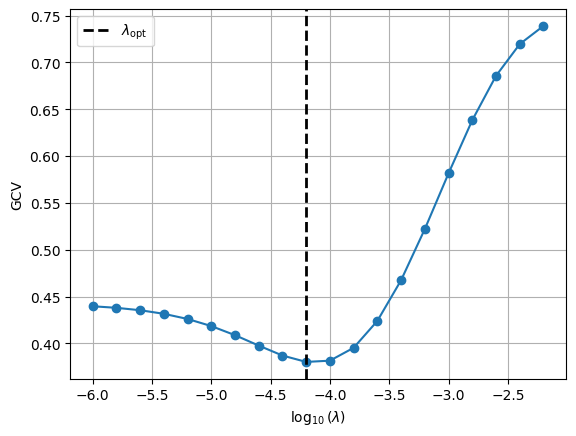

In [20]:
# GCV indices
gcv_values = fit_SST_iso_grid["values"] 

# Optimal value selected for the smoothing parameter
lambda_opt = fit_SST_iso_grid["optimum"]
print(f"lambda_opt = {lambda_opt:.4e}")

# Plot of the GCV curve
plt.plot(np.log10(lambda_grid), gcv_values, '-o')   
plt.xlabel(r"$\log_{10}(\lambda)$")
plt.ylabel("GCV")

plt.axvline(
    np.log10(lambda_opt),
    linestyle = "--",
    linewidth = 2,
    color     = "black",
    label     = r"$\lambda_{\mathrm{opt}}$"
)

plt.grid(True)
plt.legend()
plt.show()

Figure 6: GCV curve.

The GCV curve is convex with minimum realized at the optimal value selected by the method -- specifically, $6.31e-05\,.$

The regression model fit over the region of interest is displayed below.


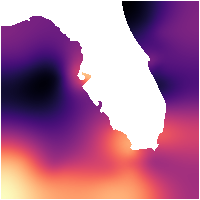
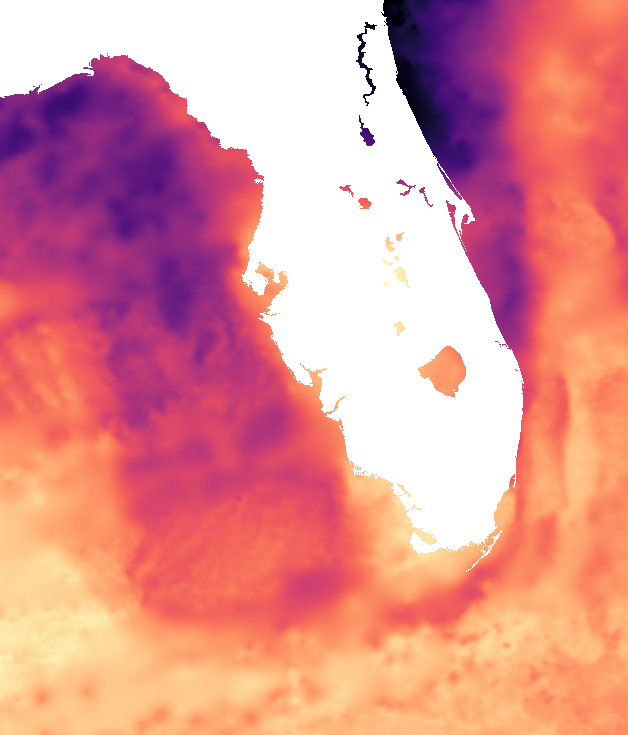

In [22]:
# Interactive plot
m_field_iso = f_SST_iso_grid.mapplot(boundary_nodes=mesh_boundary_nodes, layer_name="sst", zoom_start=6, cmap_name="magma")
m_satellite = display_satellite_data(
    raster_path = "../Data/SRPDE_2D/SST.tif", 
    layer_name = "Satellite SST", 
    boundary_nodes = mesh_boundary_nodes, 
    map_location   =[mesh_nodes[:,1].mean(), mesh_nodes[:,0].mean()] 
)

display_folium_map(
    maps=[m_field_iso, m_satellite],
    nrows=1,
    ncols=2
)

Figure 7: SST estimate provided by the isotropic `SR-PDE`$(I,\mathbf{0},0)$ without covariates and with $\lambda$ selected via GCV minimization through grid search (left); SST data from NASA satellite images (right). We recall that the latter are not used for estimation purposes; they are displayed here solely to allow comparison with the SST estimate computed by the proposed `SR-PDE` method, which instead is based on the 30 observations measured at the moored buoys.

The smoothing fit appears slightly more accurate than the previous fit compared to the satellite image data, although the anisotropy and non-stationarity behaviors are still not captured by the isotropic modeling. In the next section, we show how these effects can be included in the statistical modeling thanks to the flexibility of the `fdaPDE` package. 

### 4. SR-PDE model fitting for physics-informed smoothing (without covariates)

The phenomenon under study is heavily influenced by the *Gulf Stream*, a warm, swift, and non-stationary current in the Atlantic Ocean. The proposed `SR-PDE` method is well-suited for this type of data analysis, as it allows for the incorporation of physical knowledge into the modeling framework. In fact, the influence of the Gulf Stream on the spatial distribution of the considered oceanographic quantity can be properly captured by a *diffusion-transport PDE*. Thus, we apply **physics-informed smoothing** to the SST data, hereafter referred to as `SR-PDE`$(K,\mathbf{b},0)\,.$ This means that we consider:

- a **stationary and isotropic diffusion tensor**: $K = \eta I\,,$ where the diffusion intensity $\eta = 0.0218$ (assumed known; see, e.g.,  Bernardi et al. (2018) and Tomasetto et al. (2024)) and $I$ is the identity matrix;

- a **space-varying transport field**: $\mathbf{b}(\mathbf{p})\,,$ which stores the Gulf Stream velocity at location $\mathbf{p}\,;$

- a **null reaction coefficient**: $c = 0\,;$

- a **null forcing term**: $u \equiv 0\,.$

We specify that the reaction coefficient can be set to zero, as the shrinkage effect is not relevant to the phenomenon under study. Moreover, the relatively small value of the diffusion intensity $\eta\,,$ compared to the values assumed by $\mathbf{b}(\mathbf{p})$ over the domain of interest, highlights that the transport term has a significant impact on the phenomenon under study, as it dominates the diffusion effect.

#### 4.1 Non-Stationary Gulf stream

In this section we define the space-varying transport field $b$. Specifically, starting from the files `SRPDE_2D/Transport_x.tif` and `SRPDE_2D/Transport_y.tif`, we are able to define a function modeling the transport term at any arbitrary location $(x,y)$ using the `Rasterio` Python package (Rasterio contributors, 2025). These data -- specifically, the direction and intensity of the Gulf Stream around the Florida peninsula -- are provided by the [Ocean Surface Current Analysis Real-time (OSCAR)](https://podaac.jpl.nasa.gov/dataset/OSCAR%CB%99L4%CB%99OC%CB%99third-deg) dataset, with a 5-day resolution. 

Below, we present an image illustrating the transport term over the Gulf of Mexico.

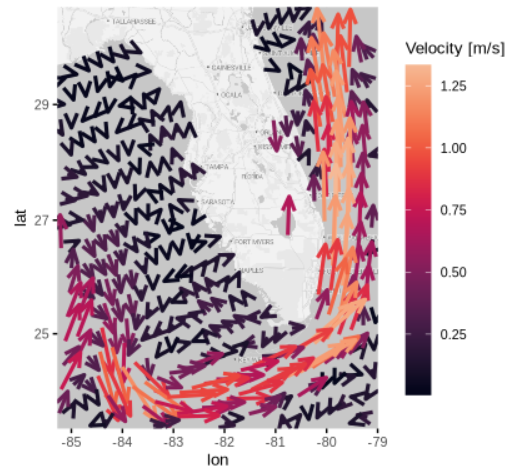

In [23]:
# Static plot
display(Image("../Data/SRPDE_2D/transport_field.png"))

Figure 8: Gulf Stream velocity around the Florida peninsula.

We can define the PDE parameters as either constant or standard Python functions. The former is used to define the constant diffusion tensor, while the latter is used to encode non-constant coefficients, such as the Gulf stream:

In [24]:
## [PDE PARAMETERS]
# Diffusion tensor
K = 0.0218 * np.eye(2)  

# Advection field
Transport_x = rxr.open_rasterio("../Data/SRPDE_2D/Transport_x.tif").squeeze()
Transport_y = rxr.open_rasterio("../Data/SRPDE_2D/Transport_y.tif").squeeze()

# extract raster values
Tx = Transport_x.values
Ty = Transport_y.values

# extract raster coordinates
x_coords = Transport_x.x.values
y_coords = Transport_x.y.values

# perform nearest neighbor search in coordinate space
def nearest_indices(coords, values):
    coords = np.asarray(coords)
    values = np.asarray(values)

    # ensure ascending for searchsorted
    if coords[0] > coords[-1]:
        coords = coords[::-1]
        reversed_axis = True
    else:
        reversed_axis = False

    idx = np.searchsorted(coords, values)
    idx = np.clip(idx, 1, len(coords) - 1)

    left = coords[idx - 1]
    right = coords[idx]

    choose_left = np.abs(values - left) <= np.abs(values - right)
    idx = idx - choose_left

    if reversed_axis:
        idx = len(coords) - 1 - idx

    return idx

# define the callable implementing the space-varying advection field
def b(points):
    points = np.asarray(points)
    xs = points[:, 0]
    ys = points[:, 1]

    ix = nearest_indices(x_coords, xs)
    iy = nearest_indices(y_coords, ys)

    tx = Tx[iy, ix]
    ty = Ty[iy, ix]

    return np.column_stack((tx, ty))

#### 4.2 Physics-informed smoothing with optimal smoothing parameter selection

The physics-informed model `SR-PDE`$(K,\mathbf{b},0)$ can be implemented in `fdaPDE` with minimal variations with respect to the isotropic example. Spefically, the `penalty` argument of `SRPDE` accept a description of the physical penalization. Here, we use the `FeElliptic` second-order operator, specifying the values for the diffusion tensor $K$ and transport field $b$. The selection of the optimal smoothing level is again here performed by minimizing the GCV index over a fixed grid of proposed values:

In [25]:
# Import fe_elliptic from fdaPDE.models module
from fdaPDE.models import FeElliptic

## [PHYSICS-INFORMED SMOOTHING WITH OPTIMAL SMOOTHING PARAMETER]
# Proposed values for the smoothing parameter
lambda_grid = 10**(np.arange(-4.0, -1.0, 0.2)) 

# Set up the finite element function (order 1)
f_SST_physics  = FeFunction(domain = mesh_florida, fe_type = "P1")

# Physics-Informed smoothing model
model_SST_physics  = SRPDE("SST ~ f_SST_physics", data = florida, penalty = FeElliptic(K = K, b=b))

# Isotropic smoothing fit with grid search for GCV minimization
fit_SST_physics = model_SST_physics.fit(calibration_ = GCV(optimizer = GridSearch(lambda_grid), seed=425)) 

We print the regression model outputs,

In [26]:
# Fitted values at mesh nodes
print(f"Fitted values at mesh nodes: {f_SST_physics.coeff[:5]}")

# Optimal value selected for the smoothing parameter
lambda_opt = fit_SST_physics["optimum"]
print(f"lambda_opt = {lambda_opt:.4e}")

Fitted values at mesh nodes: [25.76696234 24.34790909 27.50786429 23.95165296 23.94108478]
lambda_opt = 1.5849e-02


and compare the physics-informed estimate with the uninformed estimate and the satellite images in the plot below:


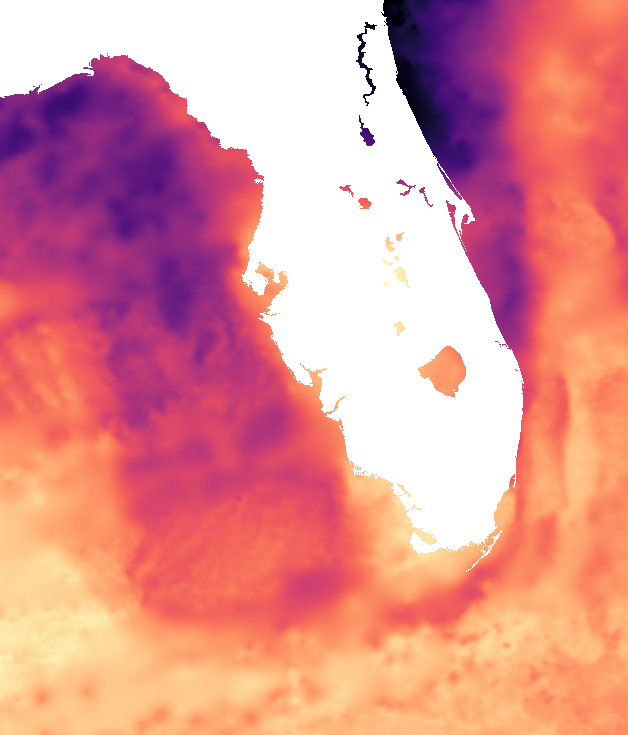
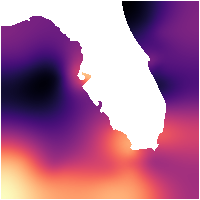
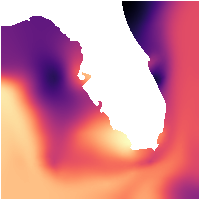

In [28]:
# Interactive plot
m_satellite = display_satellite_data(
    raster_path = "../Data/SRPDE_2D/SST.tif",
    layer_name = "Satellite SST", 
    boundary_nodes = mesh_boundary_nodes,                                 
    map_location   = [mesh_nodes[:,1].mean(), mesh_nodes[:,0].mean()] 
)
m_field_iso       = f_SST_iso_grid.mapplot(boundary_nodes=mesh_boundary_nodes, layer_name="sst iso", zoom_start=6, cmap_name="magma")
m_field_transport = f_SST_physics .mapplot(boundary_nodes=mesh_boundary_nodes, layer_name="sst physics", zoom_start=6, cmap_name="magma")

display_folium_map(
    maps=[m_satellite, m_field_iso, m_field_transport],
    nrows=1,
    ncols=3
)

Figure 9: SST data from NASA satellite images (left); SST estimate provided by the isotropic `SR-PDE`$(I,\mathbf{0},0)$ with $\lambda$ selected via GCV minimization (center); SST estimate provided by the physics-informed `SR-PDE`$(K,\mathbf{b},0)$ with $\lambda$ selected via GCV minimization (right). We recall that the latter are not used for estimation purposes; they are displayed here solely to allow comparison with the SST estimate computed by the proposed `SR-PDE` method, which instead is based on the 30 observations measured at the moored buoys.

This model fitting successfully captures the strongly anisotropic and non-stationary pattern of the SST. By leveraging problem-specific information -- specifically, the presence of the Gulf Stream -- the proposed `SR-PDE`$(K,\mathbf{b},0)$ method provides an accurate estimate of the spatial distribution of the quantity under study using only buoy measurements.

### 5. SR-PDE model fitting for physics-informed smoothing (with covariates)

The `SR-PDE` model can incorporate **covariates** associated with the corresponding observed data values. We present an example based on the Nitrate data, measured in $\mu\,\text{g} / \text{L}\,$ and modeled using the Sea Surface Temperature (SST) as a covariate. The recorded values for SST and Nitrate are shown in the interactive plots below.

In [30]:
# Interactive plot for DO and SST variable
m_sst      = florida["ocean"].mapplot("SST", boundary_nodes=mesh_boundary_nodes, cmap_name="viridis")
m_nitrate  = florida["ocean"].mapplot("Nitrate",  boundary_nodes=mesh_boundary_nodes, cmap_name="viridis")

display_folium_map(
    maps=[m_sst, m_nitrate],
    nrows=1,
    ncols=2
)

Figure 10: SST (left) and Nitrate (right) observed at 30 monitoring stations located in the Gulf of Mexico, around the Florida peninsula, on April 1, 2020.

Nitrate is strongly negatively correlated with SST, with a Pearson correlation coefficient of approximately −0.4052.

In [31]:
pearson_corr = data["SST"].corr(data["Nitrate"], method="pearson")
print(pearson_corr)

-0.4051917044923265


The model fitting is obtained keeping the same PDE parameters and expressing the relationship between the Nitrate and the SST via R-formula syntax

In [32]:
## [PHYSICS-INFORMED SMOOTHING WITH OPTIMAL SMOOTHING PARAMETER]
# Proposed values for the smoothing parameter
lambda_grid = 10**(np.arange(-6.0, -3.0, 0.2)) 

# Set up the finite element function (order 1)
f_nitrate_physics  = FeFunction(domain = mesh_florida, fe_type = "P1")

# Semiparametric smoothing model
model_nitrate_physics  = SRPDE("Nitrate ~ SST + f_nitrate_physics", data = florida, penalty = FeElliptic(K = K, b=b))

# Isotropic smoothing fit with grid search for GCV minimization
fit_nitrate_physics = model_nitrate_physics.fit(calibration_ = GCV(optimizer = GridSearch(lambda_grid), seed=425)) 

We print the regression model outputs.

In [33]:
# Fitted values at mesh nodes
print(f"Fitted values at mesh nodes: {f_nitrate_physics.coeff[:5]}")
print(f"Fitted beta: {model_nitrate_physics.beta}")  

Fitted values at mesh nodes: [0.72824052 1.01351547 0.78269017 0.41900287 0.41936044]
Fitted beta: [-0.01788894]


The regression model fit over the region of interest is instead displayed below.


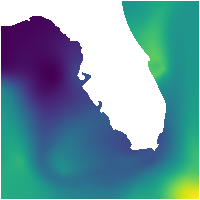

In [34]:
# Interactive plot
m_field_nitrate = f_nitrate_physics.mapplot(
    boundary_nodes = mesh_boundary_nodes,
    layer_name     = "f_nitrate",
    zoom_start     = 6,
    cmap_name      = "viridis"
)

m_data_nitrate = florida["ocean"].mapplot("Nitrate",  boundary_nodes=mesh_boundary_nodes, cmap_name="viridis")

display_folium_map(
    maps=[m_field_nitrate, m_data_nitrate],
    nrows=1,
    ncols=2
)

Figure 12: Nitrate estimate provided by the physics-informed `SR-PDE`$(K,\mathbf{b},0)$ with optimal $\lambda$ selected via GCV minimization using using grid search method and using SST as a covariate (left); Nitrate data observed at 30 monitoring stations located in the Gulf of Mexico (right).

This model fitting successfully proves to capture the strongly anisotropic and non-stationary pattern exhibited by the Nitrate data, leveraging both the physics of the underlying phenomenon and information from the SST data.

## References

Arnone, E., Azzimonti, L., Nobile, F., & Sangalli, L. M. (2019). Modeling spatially dependent functional data via regression with differential regularization. Journal of Multivariate Analysis, 170, 275–295. https://doi.org/10.1016/j.jmva.2018.09.006

Arnone, E., Negri, L., Panzica, F., & Sangalli, L. M. (2023). Analyzing data in complicated 3D domains: Smoothing, semiparametric regression, and functional principal component analysis. Biometrics, 79(4), 3510–3521. https://doi.org/10.1111/biom.13845

Azzimonti, L., Nobile, F., Sangalli, L. M., & Secchi, P. (2014). Mixed finite elements for spatial regression with PDE penalization. SIAM/ASA Journal on Uncertainty Quantification, 2(1), 305–335. https://doi.org/10.1137/130925426

Azzimonti, L., Sangalli, L. M., Secchi, P., Domanin, M., & Nobile, F. (2015). Blood flow velocity field estimation via spatial regression with PDE penalization. Journal of the American Statistical Association, 110(511), 1057–1071. https://doi.org/10.1080/01621459.2014.946036

Bernardi, M. S., Carey, M., Ramsay, J. O., & Sangalli, L. M. (2018). Modeling spatial anisotropy via regression with partial differential regularization. Journal of Multivariate Analysis, 167, 15–30. https://doi.org/10.1016/j.jmva.2018.03.014

Ettinger, B., Perotto, S., & Sangalli, L. M. (2016). Spatial regression models over two-dimensional manifolds. Biometrika, 103(1), 71–88.

GeoPandas Developers. (2024). GeoPandas (Version 1.1.2) [Computer software]. https://geopandas.org

Palummo, A., Clemente, A., Sangalli, E., Arnone, Formaggia, L., & Maria, L. (2025). fdaPDE: Physics-informed statistical learning. url: https://github.com/fdaPDE/fdaPDE-R.

Python Visualization Team. (2024). Folium (Version 0.20.0) [Computer software]. https://github.com/python-visualization/folium

Rasterio contributors. (2025). Rasterio (Version 1.5.0) [Computer software]. https://github.com/rasterio/rasterio

Sangalli, L. M. (2021). Spatial regression with partial differential equation regularisation. International Statistical Review, 89(3), 505–531. https://doi.org/10.1111/insr.12444

Sangalli, L. M., Ramsay, J. O., & Ramsay, T. O. (2013). Spatial spline regression models. Journal of the Royal Statistical Society Series B: Statistical Methodology, 75(4), 681–703. https://doi.org/10.1111/rssb.12009

Tomasetto, M., Arnone, E., & Sangalli, L. M. (2024). Modeling anisotropy and non-stationarity through physics-informed spatial regression. Environmetrics, 35(8). https://doi.org/10.1002/env.2889